In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors

import geopy.distance
import folium
from folium.plugins import MarkerCluster

import warnings
from tqdm import tqdm

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Sección A: Datos abiertos de la CDMX

La Agencia Digital de Innovación Pública tiene disponibles datos de las carpetas de investigación aportados por la PGJ. La tabla está disponible aquí: [Carpetas de Investigación de la FGJ](https://datos.cdmx.gob.mx/dataset/carpetas-de-investigacion-fgj-de-la-ciudad-de-mexico/resource/48fcb848-220c-4af0-839b-4fd8ac812c0f). Utilizando estos datos, responde las siguientes preguntas. Debes de desarrollar el código en Python:

In [2]:
# Primero hay que dercargar los datos de la liga de arriba y ponerlos en el directorio actual
data = pd.read_csv('carpetas_completa_septiembre_2021.csv')
data.head()

,ao_hechos,mes_hechos,fecha_hechos,ao_inicio,mes_inicio,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,categoria_delito,calle_hechos,calle_hechos2,colonia_hechos,alcaldia_hechos,competencia,longitud,latitud,tempo
0,2016.0,Enero,2016-01-31 22:16:00,2016,Febrero,2016-02-01 00:25:44,DAÑO EN PROPIEDAD AJENA INTENCIONAL,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-2,UI-3CD,DELITO DE BAJO IMPACTO,CALZ. DE TLALPAN,LAGO PTE.,AMÉRICAS UNIDAS,BENITO JUAREZ,NaN,-99.140215,19.380315,NaN
1,2016.0,Enero,2016-01-31 20:50:00,2016,Febrero,2016-02-01 00:52:37,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,INVESTIGACIÓN PARA LA ATENCIÓN DEL DELITO DE R...,ORIENTEII,UI-3CD,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SUR 25 A,GRANJEROS,LOS CIPRESES,IZTAPALAPA,NaN,-99.108403,19.352859,NaN
2,2016.0,Febrero,2016-02-01 00:30:00,2016,Febrero,2016-02-01 01:33:26,NARCOMENUDEO POSESION SIMPLE,"INVESTIGACIÓN PARA LA ATENCIÓN DE NIÑOS, NIÑAS...",57,UI-3CD,DELITO DE BAJO IMPACTO,BATALLONES ROJOS,NaN,UNIDAD VICENTE GUERRERO,IZTAPALAPA,NaN,-99.061321,19.356451,NaN
3,2016.0,Enero,2016-01-31 22:00:00,2016,Febrero,2016-02-01 02:09:11,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,INVESTIGACIÓN EN IZTAPALAPA,IZP-6,UI-3CD,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,GERANIO,GAVILLEROS,EMILIANO ZAPATA,IZTAPALAPA,NaN,-98.976379,19.331633,NaN
4,2015.0,Diciembre,2015-12-25 12:00:00,2016,Febrero,2016-02-01 02:16:49,DENUNCIA DE HECHOS,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-1,UI-3SD,HECHO NO DELICTIVO,SAN FRANCISCO,AVENIDA COLONIA DEL VALLE,DEL VALLE CENTRO,BENITO JUAREZ,NaN,-99.172189,19.387114,NaN


1. ¿Qué pruebas identificarías para asegurar la calidad de estos datos? No es necesario hacerlas, sólo describe la prueba y lo que te dice cada una.

- **Completitud:** se refiere a si no hay valores faltantes, lo que podemos hacer fácilmente contando cuántos valores faltan por columna.
- **Precisión:** ¿qué tan bien refleja la información la realidad? Para eso tendríamos que ver qué tan fiable es la fuente de los datos, en este caso como es de la FGJ podemos pensar que son un buen reflejo de lo que realmente está pasando.
- **Temporalidad:** los datos deben estar actualizados para la tarea, dado que se tienen los últimos 5 años de delitos parece ser un buen punto de partida.

2. Identifica los delitos que van a la alza y a la baja en la CDMX (ten cuidado con los delitos con pocas ocurrencias).

  - Los datos son principalmente de la CDMX, aunque también hay algunas alcaldías del Estado de México y otros estados de la república, por lo que hay que filtrarlos.

  - En cuanto a las ocurrencias de los delitos hay algunos que tienen una gran cantidad de reportes (como *VIOLENCIA FAMILIAR* con 136,416) y otros que tienen muy pocas ocurrencias. Por el momento tomaré los delitos con más de 10,000 ocurrencias. Podemos ver *'a ojo'* la tendencia graficando o podemos ser más formales y sacar la tendencia de cada delito.
  
En las gráficas de abajo podemos ver que de los delitos más frecuentes (aquellos con 10,000 ocurrencias o más) los que tienen una clara tendencia a la alza son:

- Violencia familiar
- Fraude
- Amenazas
- Robo de accesorios de auto
- Abuso de confianza
- Despojo
- Falsificación de títulos al portador y documentos de crédito público
- Abuso sexual
- Usurpación de identidad
- Tentativa de extorsión

In [3]:
alcaldias_cdmx = ['AZCAPOTZALCO', 'ALVARO OBREGON', 'BENITO JUAREZ', 'COYOACAN', 'CUAJIMALPA DE MORELOS',
                  'CUAUHTEMOC', 'GUSTAVO A MADERO', 'IZTACALCO', 'IZTAPALAPA', 'LA MAGDALENA CONTRERAS',
                  'MIGUEL HIDALGO', 'MILPA ALTA', 'TLALPAN', 'TLAHUAC', 'VENUSTIANO CARRANZA', 'XOCHIMILCO']

# Datos correspondientes a alcaldías de la CDMX
data_cdmx = data[data['alcaldia_hechos'].isin(alcaldias_cdmx)]
# En lo siguiente usaré seguido la columna 'fecha_inicio', por lo que quitaré los nan de ahi (son sólo 3)
data_cdmx = data_cdmx[data_cdmx['fecha_inicio'].notna()]

In [4]:
# Obtenemos los delitos con una ocurrencia total mayor a 10,000.
delitos_frecuentes = (data_cdmx['delito'].value_counts() > 10000).to_frame().reset_index()
delitos_frecuentes.columns = ['delito', 'es_frecuente']
delitos_frecuentes = delitos_frecuentes[delitos_frecuentes['es_frecuente']]
delitos_frecuentes = delitos_frecuentes['delito'].tolist()

In [5]:
# Agrupamos por delito y fecha
delitos_cdmx = data_cdmx[['fecha_inicio', 'delito', 'alcaldia_hechos']]
delitos_cdmx['fecha_inicio'] = delitos_cdmx['fecha_inicio'].apply(lambda x: pd.Timestamp(x)).dt.to_period('M')
delitos_cdmx = delitos_cdmx[['delito', 'fecha_inicio']].groupby(['delito', 'fecha_inicio']).size().reset_index()
delitos_cdmx.columns = ['delito', 'fecha_inicio', 'cuenta']

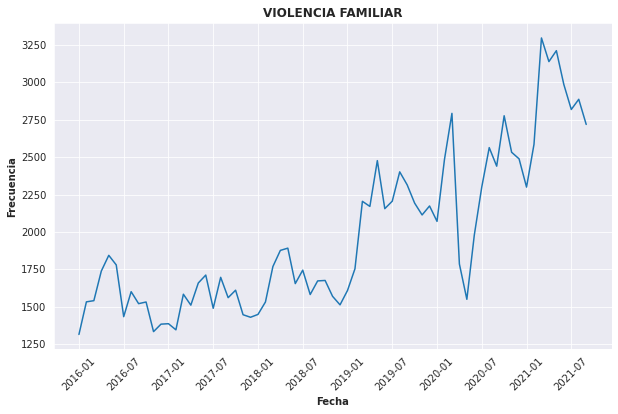

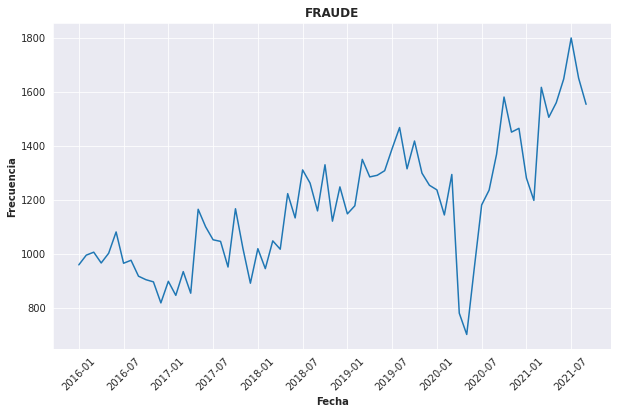

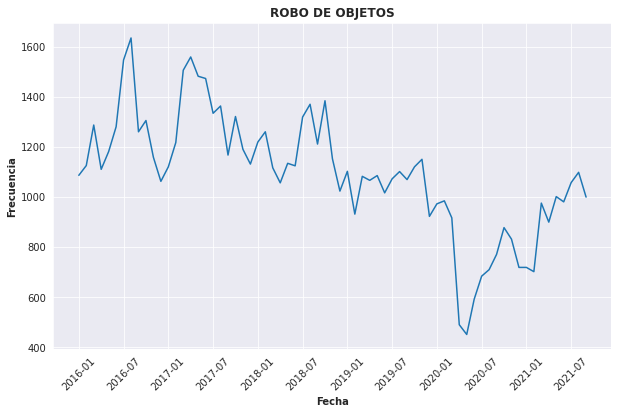

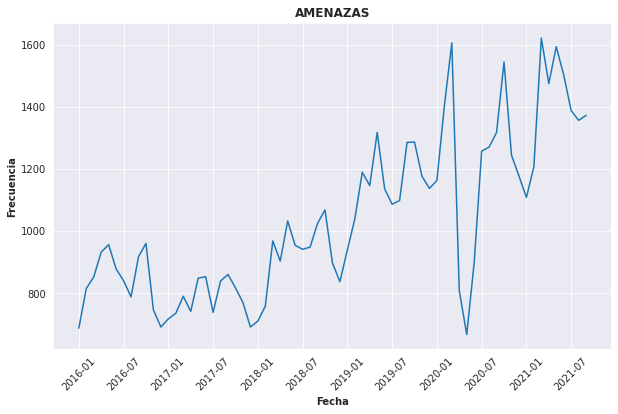

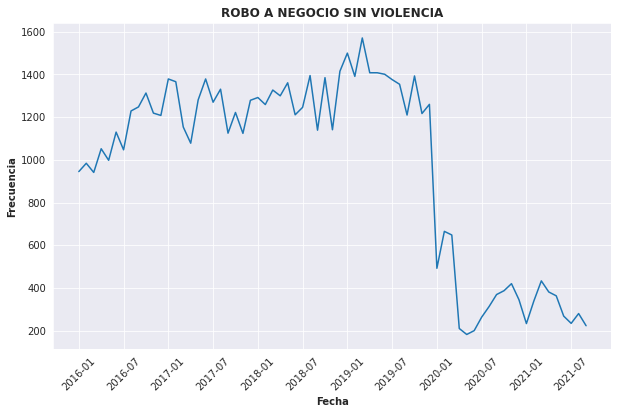

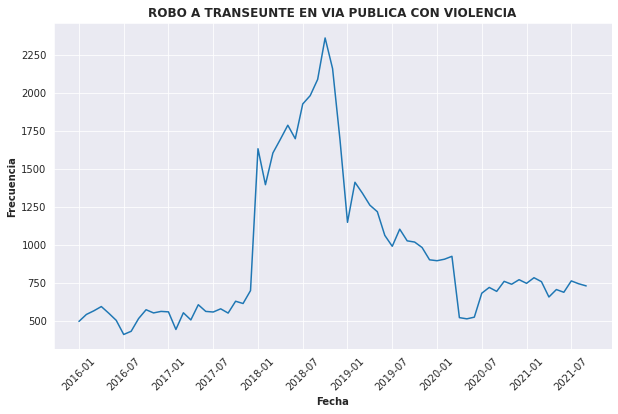

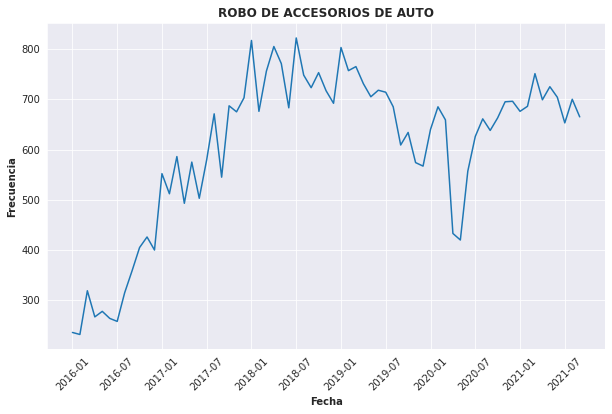

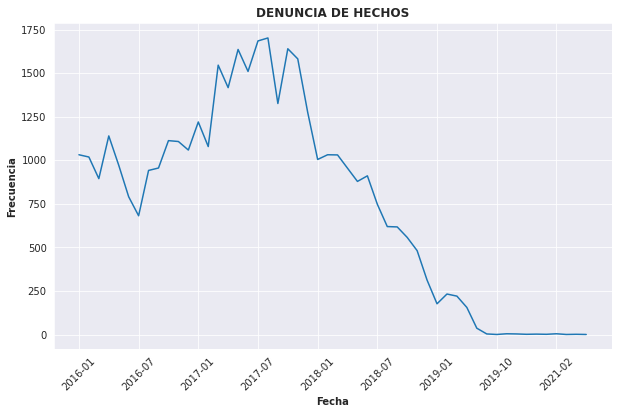

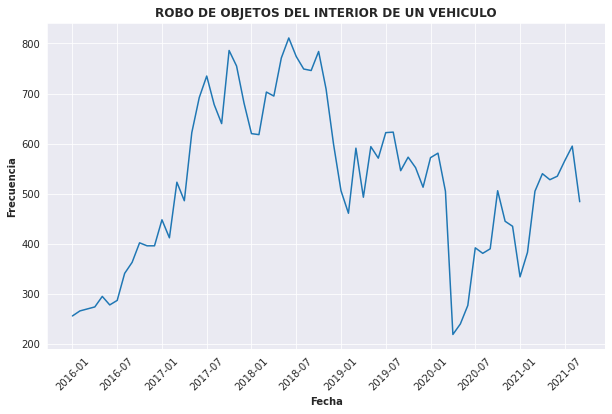

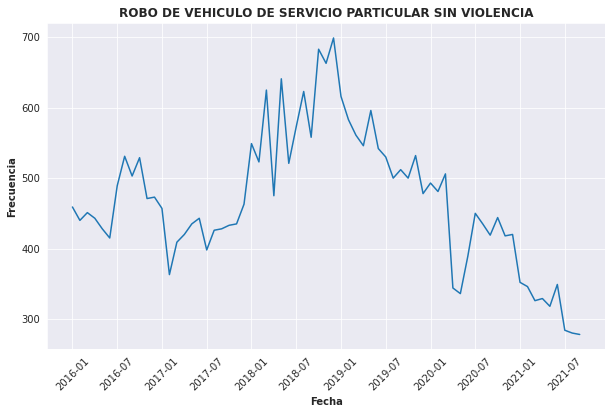

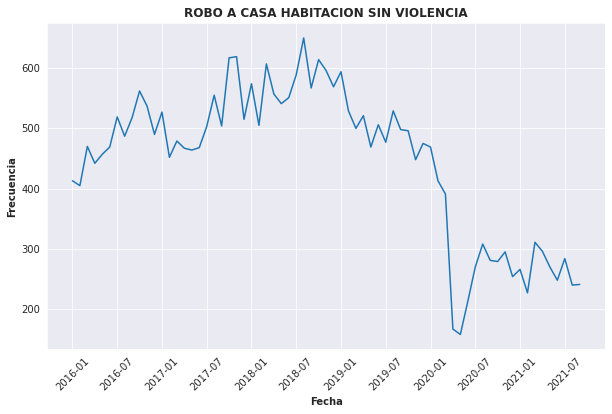

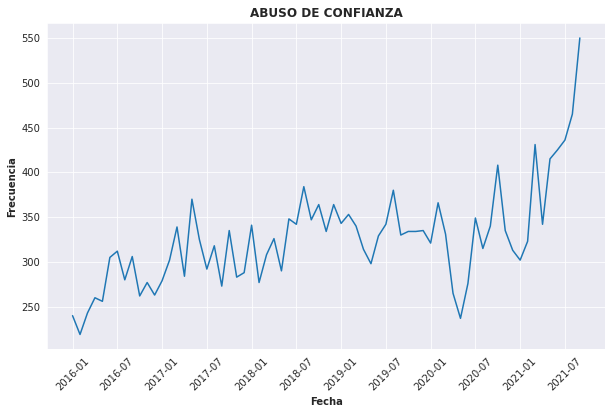

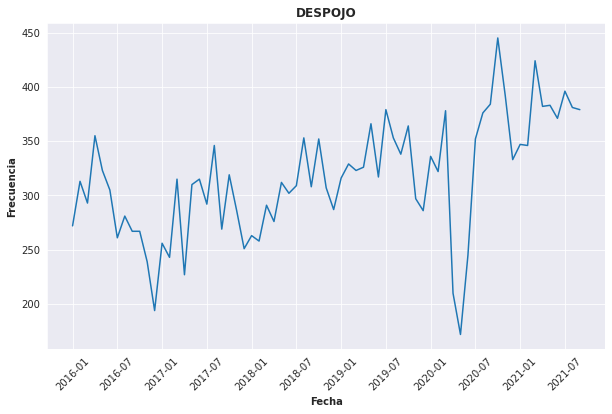

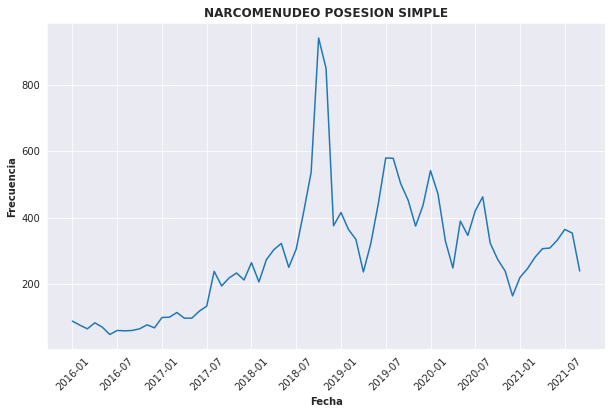

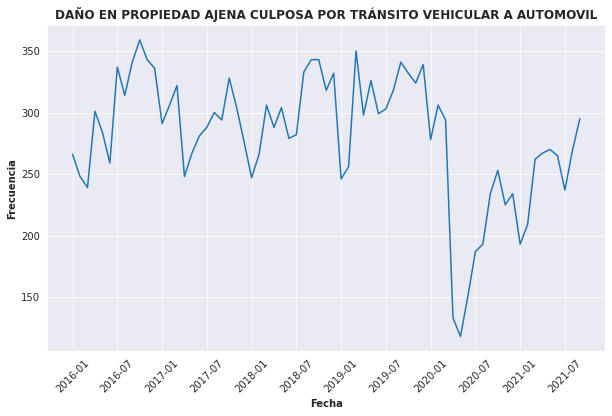

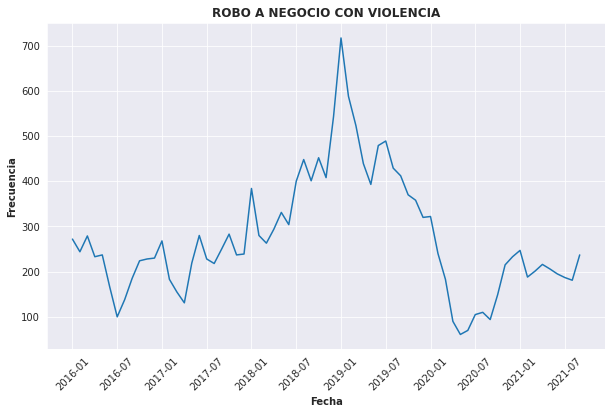

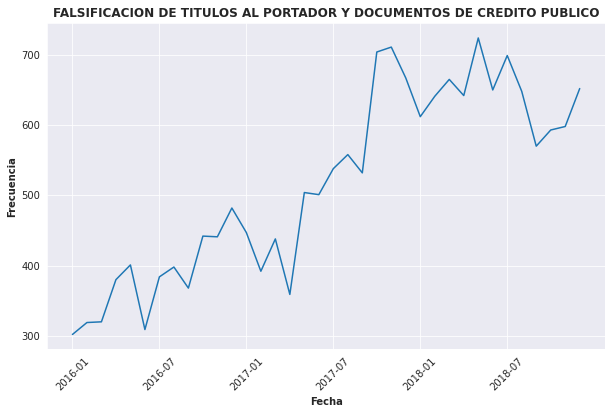

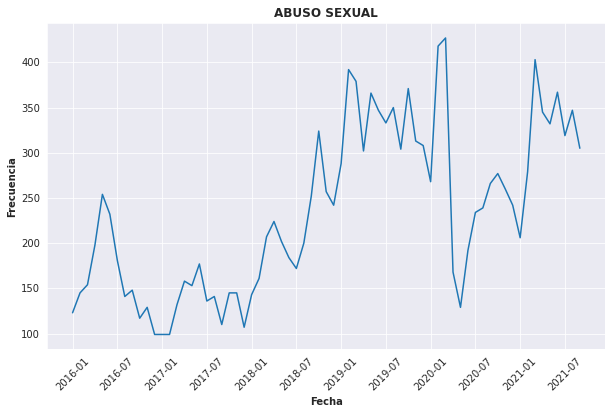

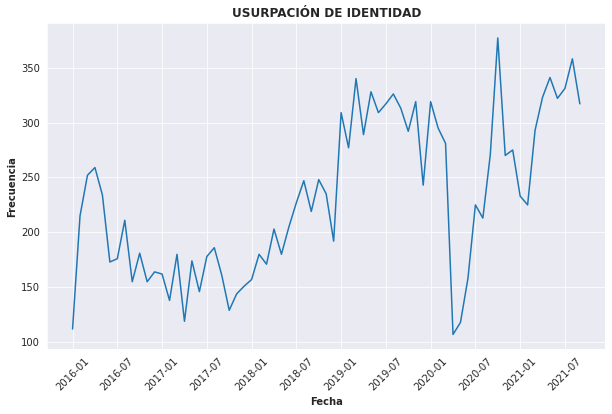

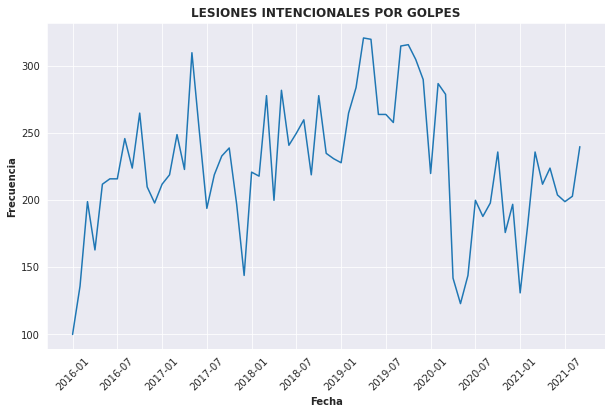

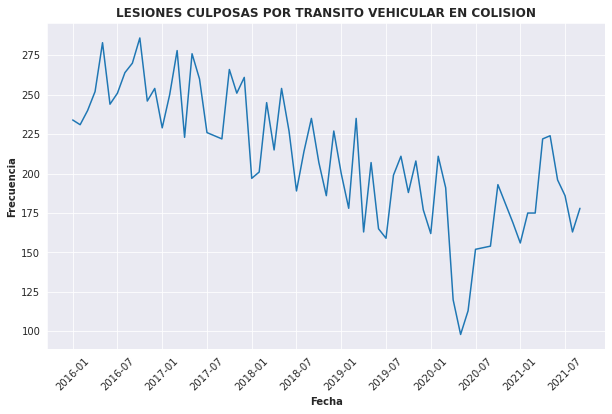

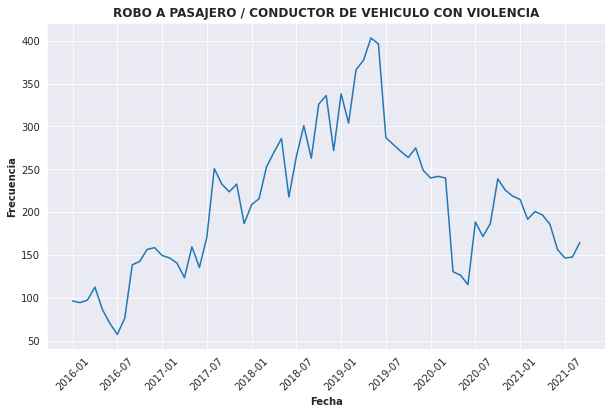

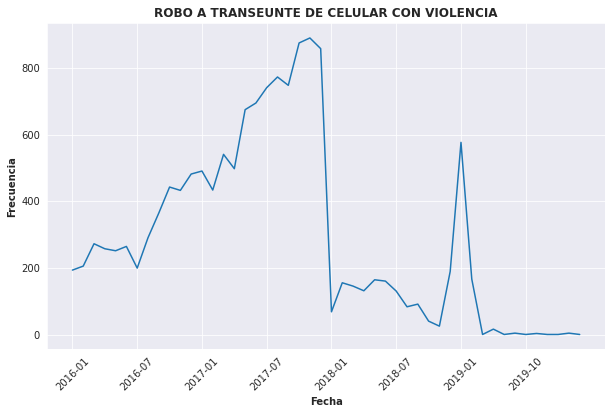

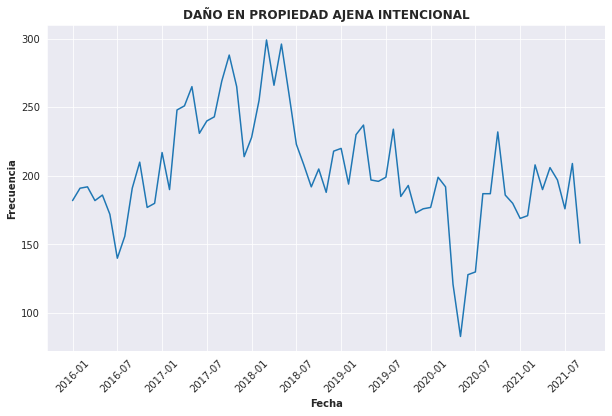

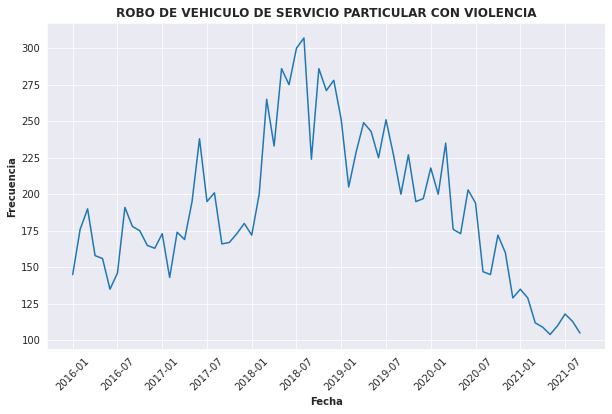

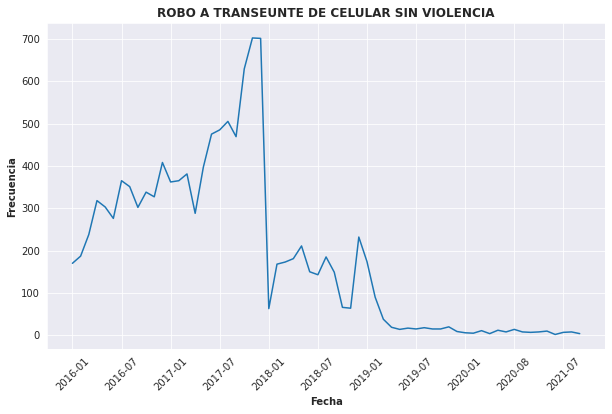

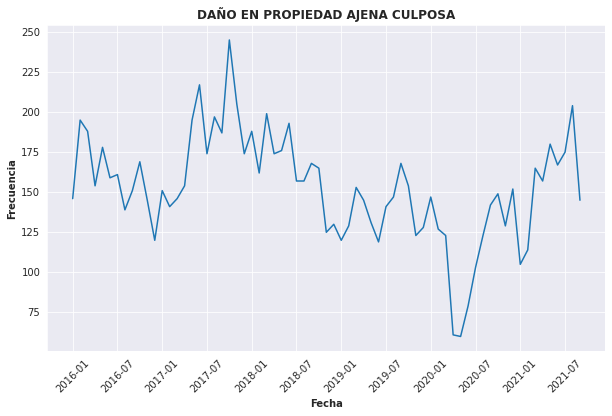

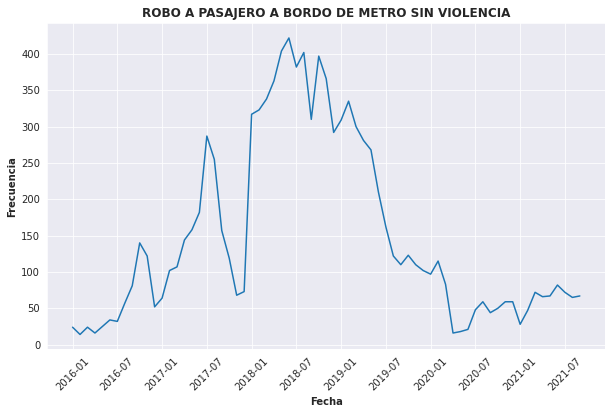

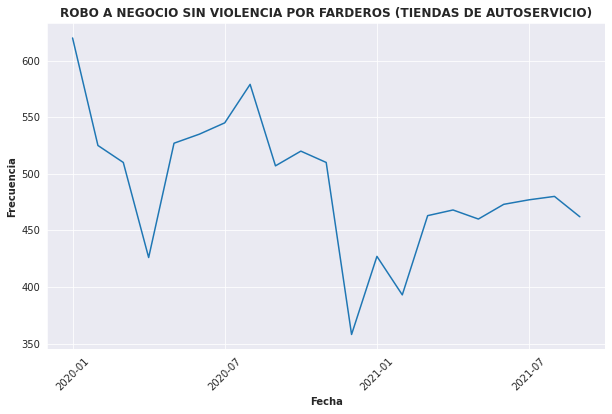

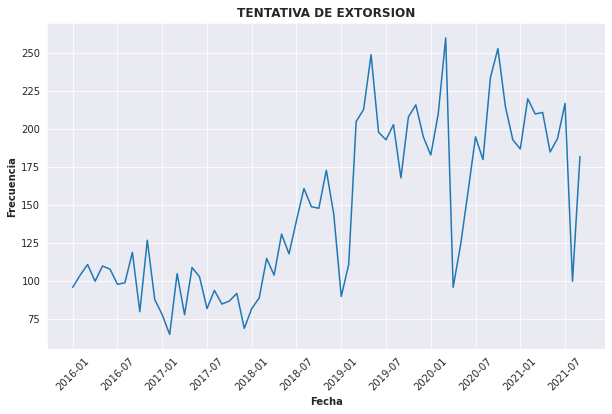

In [6]:
for delito in delitos_frecuentes:
    df = delitos_cdmx[delitos_cdmx['delito'] == delito]
    
    plt.figure(figsize=(10,6))
    plt.plot(df['fecha_inicio'].apply(lambda x: str(x)), df['cuenta'])
    
    plt.title(delito, weight='bold')
    plt.xlabel('Fecha', weight='bold')
    plt.ylabel('Frecuencia', weight='bold')
    plt.xticks(np.arange(0, len(df), step=6))
    plt.xticks(rotation=45)
    plt.show()

3. ¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos? ¿Por qué crees que sea esto?

La alcaldía con más delitos en la CDMX es Cuauhtémoc y la que tiene menos es Milpa Alta. Podemos pensar que Milpa Alta es la que tiene menos delitos por ser la alcaldía con menor población de la CDMX. Por otro lado, Cuauhtémoc no es la alcaldía más poblada pero está en el centro de la CDMX, donde se concentra una parte importante de la actividad económica de la CDMX y por lo tanto recibe un flujo importante de personas diariamente.

Así, podemos esperar que haya más delitos entre más personas vivan o laboren en una alcaldía, por ejemplo, Iztapalapa y Gustavo A. Madero son las alcaldías más pobladas y le siguen a Cuauhtémoc en delitos, mientras que Cuajimalpa de Morelos y La Magdalena Contreras son de las menos pobladas después de Milpa Alta y también tienen pocos delitos. 

In [7]:
data_cdmx['alcaldia_hechos'].value_counts()

CUAUHTEMOC                203425
IZTAPALAPA                196158
GUSTAVO A MADERO          131318
BENITO JUAREZ             107516
ALVARO OBREGON             88946
COYOACAN                   87401
MIGUEL HIDALGO             84626
TLALPAN                    76791
VENUSTIANO CARRANZA        75034
AZCAPOTZALCO               63569
IZTACALCO                  54310
XOCHIMILCO                 41203
TLAHUAC                    32444
LA MAGDALENA CONTRERAS     21513
CUAJIMALPA DE MORELOS      19527
MILPA ALTA                  9561
Name: alcaldia_hechos, dtype: int64

4. ¿Existe alguna tendencia estacional en la ocurrencia de delitos (mes, semana, día de la semana, quincenas) en la CDMX? ¿A qué crees que se deba?

A nivel mes no parece haber gran diferencia, a nivel día de la semana es interesante ver que en los fines de semana baja el número de delitos y  a nivel semana del año es interesante notar que las últimas dos semanas del año los delitos disminuyen considerablemente.

La razón de que bajen los fines de semana así como las últimas dos semanas del año puede ser debido a que una parte importante de la población no labora en esas fechas y se queden en sus casas.

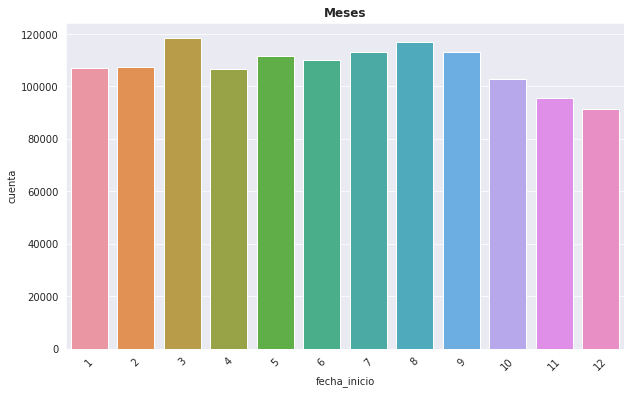

In [8]:
data_month = data_cdmx['fecha_inicio'].apply(lambda x: pd.Timestamp(x).month).to_frame()
data_month = data_month['fecha_inicio'].value_counts().reset_index()
data_month.columns = ['fecha_inicio', 'cuenta']
data_month.sort_values('fecha_inicio', inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='fecha_inicio', y='cuenta', data=data_month)

plt.title('Meses', weight='bold')
plt.xticks(rotation=45)
plt.show()

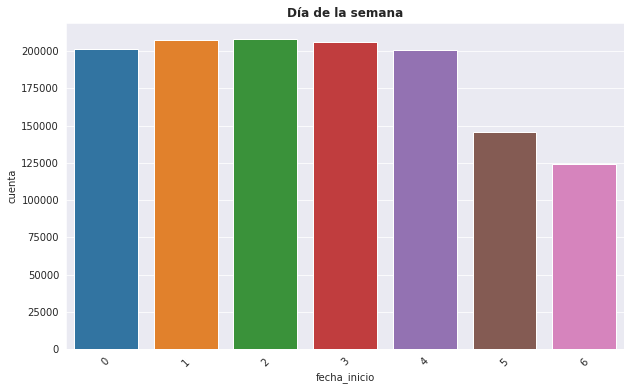

In [9]:
data_dayofweek = data_cdmx['fecha_inicio'].apply(lambda x: pd.Timestamp(x).dayofweek).to_frame()
data_dayofweek = data_dayofweek['fecha_inicio'].value_counts().reset_index()
data_dayofweek.columns = ['fecha_inicio', 'cuenta']
data_dayofweek.sort_values('fecha_inicio', inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='fecha_inicio', y='cuenta', data=data_dayofweek)

plt.title('Día de la semana', weight='bold')
plt.xticks(rotation=45)
plt.show()

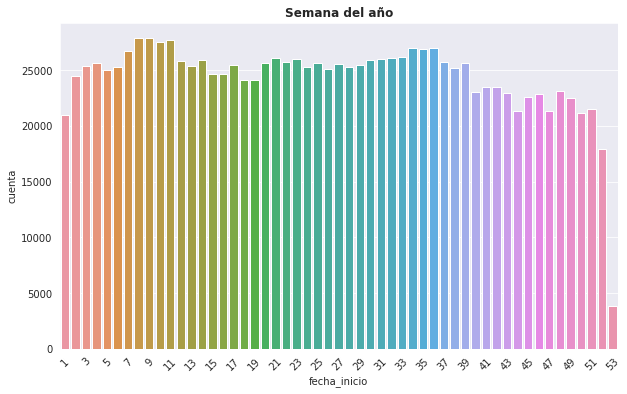

In [10]:
data_week = data_cdmx['fecha_inicio'].apply(lambda x: pd.Timestamp(x).week).to_frame()
data_week = data_week['fecha_inicio'].value_counts().reset_index()
data_week.columns = ['fecha_inicio', 'cuenta']
data_week.sort_values('fecha_inicio', inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='fecha_inicio', y='cuenta', data=data_week)

plt.title('Semana del año', weight='bold')
plt.xticks(np.arange(0, 53, step=2))
plt.xticks(rotation=45)
plt.show()

5. ¿Cuáles son los delitos que más caracterizan a cada alcaldía? Es decir, delitos que suceden con mayor frecuencia en una alcaldía y con menor frecuencia en las demás.

In [11]:
delitos_caracteristicos = data_cdmx[['alcaldia_hechos', 'delito']].groupby(['alcaldia_hechos', 'delito']).size().reset_index(name='cuenta')
delitos_frecuentes_vistos = []
frecuencias = []
cuentas = []

for alcaldia in alcaldias_cdmx:
    df = delitos_caracteristicos[delitos_caracteristicos['alcaldia_hechos'] == alcaldia].reset_index(drop=True)
    df['frecuencia'] = df['cuenta'] / df['cuenta'].sum()
    df.sort_values('frecuencia', ascending=False, ignore_index=True, inplace=True)
    
    i = 0
    flag = True
    while flag:
        alcaldia_hechos, delito, cuenta, frecuencia = df.loc[i]
        # Si no es el más frecuente en las otras alcaldías vista se anexa
        if delito not in delitos_frecuentes_vistos:
            flag = False
            delitos_frecuentes_vistos.append(delito)
            cuentas.append(cuenta)
            frecuencias.append(frecuencia)
        # Trata con el siguiente delito más frecuente
        else:
            i += 1

In [12]:
data_delitos_frecuentes_por_alcaldia = pd.DataFrame(data={'alcaldia': alcaldias_cdmx, 
                                                          'delito': delitos_frecuentes_vistos,
                                                          'cuenta': cuentas,
                                                          'frecuencia': frecuencias})
data_delitos_frecuentes_por_alcaldia

,alcaldia,delito,cuenta,frecuencia
0,AZCAPOTZALCO,VIOLENCIA FAMILIAR,6585,0.103588
1,ALVARO OBREGON,AMENAZAS,5237,0.058878
2,BENITO JUAREZ,FRAUDE,10866,0.101064
3,COYOACAN,ROBO DE OBJETOS,5965,0.068249
4,CUAJIMALPA DE MORELOS,ROBO A NEGOCIO SIN VIOLENCIA,1297,0.066421
5,CUAUHTEMOC,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,9876,0.048549
6,GUSTAVO A MADERO,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,4323,0.032920
7,IZTACALCO,DENUNCIA DE HECHOS,1854,0.034137
8,IZTAPALAPA,NARCOMENUDEO POSESION SIMPLE,4463,0.022752
9,LA MAGDALENA CONTRERAS,ROBO A CASA HABITACION SIN VIOLENCIA,868,0.040348


6. Diseña un indicador que mida el nivel de “inseguridad”. Genéralo al nivel de desagregación que te parezca más adecuado (ej. manzana, calle, AGEB, etc.). Analiza los resultados. ¿Encontraste algún patrón interesante? ¿Qué decisiones se podrían tomar con el indicador?

Ya que se tienen las coordenadas se podrían usar para determinar qué tan inseguro es un lugar dado sus alrededores, por lo que se puede tomar una estrategia similar a *k-nearest neighbors*. Particularmente, sea $\pmb{x}$ una ubicación de interés y sean $\{\pmb{x}_{i} \mid i=1,...,n\}$ las ubicaciones de los $n$ delitos más cercanos, proponemos que el índice de inseguridad sea

$$ \text{inseguridad}(\pmb{x}) =  \dfrac{1}{n} \sum_{i=1}^{n} f(\pmb{x}, \pmb{x}_{i}), \tag{1} $$

donde $f(\pmb{x}, \pmb{x}_{i}) = 1$ si la distancia de $\pmb{x}$ a $\pmb{x}_{i}$ es menor a determinada $r$ y $ f(\pmb{x}, \pmb{x}_{i}) = 0$ si es mayor. De esa manera, este índice irá de 0 a 1, donde 0 significa que en los alrededores no hay delitos mientras que 1 significa que en los alrededores hay muchos delitos. Los valores $n$ y $r$ son hiperparámetros a elegir.

In [13]:
data_coordenadas = data_cdmx[['latitud', 'longitud']]
data_coordenadas.dropna(inplace=True)

nearest_neighbors = NearestNeighbors(n_neighbors=100)
nearest_neighbors.fit(data_coordenadas)

NearestNeighbors(n_neighbors=100)

In [14]:
def indice_de_inseguridad(x, nearest_neighbors, n=100, r=0.5):
    """
    Calcula el índice propuesto en la ecuación 1 de arriba
    
    x: array/list.
        Array con (latitud, longitud).
    
    nearest_neighbors: sklearn.neighbors.NearestNeighbors
        Instancia ya 'entrenada' de NearestNeighbors.
        
    n: int, default=20.
        Número de vecinos más cercanos a considerar
        
    r: float, default=0.25.
        Distancia a considerar en km.
    """
    
    indices = nearest_neighbors.kneighbors(x, n_neighbors=n, return_distance=False)[0]
    kneighbors_coordinates = [nearest_neighbors._fit_X[i] for i in indices]
    scores = [1 if geopy.distance.vincenty(x[0], neighbor).km < r else 0 for neighbor in kneighbors_coordinates]
    inseguridad = np.mean(scores)
    
    return inseguridad

In [15]:
data_coordenadas_sample = data_coordenadas.sample(n=2000, random_state=0)
scores = []
for x in data_coordenadas_sample.values:
    # Hay que encontrar un buen valor para r
    score = indice_de_inseguridad(np.array([x]), (nearest_neighbors), r=0.05)
    scores.append(score)
    
data_coordenadas_sample['indice de inseguridad'] = scores

Ahora con la idea de que un lugar es seguro si en los alrededores no hay crímenes hagamos una visualización de esta idea. De esa manera podemos ver qué tantos crímenes hay en un área y medir el índice de inseguridad propuesto (aunque por cuestiones de visualización sólo puse 1000 ubicaciones ya que con todos los crímenes el mapa se vuelve pesado). Podemos notar que las áreas con una cantidad importante de delitos están por el centro de la CDMX (recordemos que Cuauhtémoc es la alcaldía con más delitos), además, podemos ver las distintas granularidades al hacer el zoom al mapa, lo que nos dice dónde hay que reforzar la seguridad en la CDMX.

In [16]:
m = folium.Map(tiles ='OpenStreetMap', zoom_start=10, location=[19.432608, -99.133208])
markerCluster = MarkerCluster().add_to(m)

for x in data_coordenadas_sample.values:
    popup = f'Índice de inseguridad: {x[2]}'
    folium.Marker(location=x[0:2], popup=popup).add_to(markerCluster)
    
m

# Sección B: BOPS

Analiza este [caso](https://drive.google.com/file/d/1w_nANIKniuhYisD11LEYJmMPYDBSlibq/view) y responde las siguientes preguntas:

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;margin:0px auto;}
.tg td{background-color:#fff;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;
  word-break:normal;}
.tg th{background-color:#f0f0f0;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-dzk6{background-color:#f9f9f9;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-baqh">Time period</th>
    <th class="tg-baqh"><span style="font-weight:bold">Online sales</span><br>Avg. sales per week per DMA</th>
    <th class="tg-baqh"><span style="font-weight:bold">B&amp;M sales</span><br><span style="font-weight:400;font-style:normal">Avg. sales per week per store</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-dzk6">Before BOPS</td>
    <td class="tg-dzk6">04/11/2011 to 10/10/2011</td>
    <td class="tg-dzk6">14,738</td>
    <td class="tg-dzk6">67,646</td>
  </tr>
  <tr>
    <td class="tg-baqh">After BOPS</td>
    <td class="tg-baqh"><span style="font-weight:400;font-style:normal">10/10/2011 to 04/11/2012</span></td>
    <td class="tg-baqh">12,734</td>
    <td class="tg-baqh">60,101</td>
  </tr>
  <tr>
    <td class="tg-dzk6"></td>
    <td class="tg-dzk6">Change</td>
    <td class="tg-dzk6">2,004</td>
    <td class="tg-dzk6">7,545</td>
  </tr>
</tbody>
</table>

In [17]:
data_online = pd.read_csv('BOPS_case/bops_online.csv')
data_store = pd.read_csv('BOPS_case/bops_bm.csv')

1. ¿Cuántos millones de dólares se ganaron o perdieron a causa del programa? ¿Deberían expandirse a Canadá? Explica tu razonamiento y metodología.

Primero que nada hay que notar que no se tiene el mismo periodo de ventas para 'Before BOPS' y 'After BOPS', por lo que puede haber otros factores además de la introducción de BOPS que no estemos considerando, como:

- Estacionalidad: como ya se mencionó no se tiene el mismo periodo de tiempo, en los distintos meses del año puede gaber distintas tendencias de compra.
- Economía: durante ese tiempo la economía pudo haber empeorado, lo que podría afectar las ventas.
- Factores de la compañía: cosas como marketing, competidores, etc pueden afectar las ventas.

Todos estos factores que no vemos pueden afectar las ventas y podemos atribuírselo erróneamente a BOPS. Necesitamos dos grupos en el mismo intervalo que nos permitan medir si BOPS ayuda o no. 

Para las ventas en línea podemos usar qué tan lejos está el DMA, ya que si el DMA está lejos no hay BOPS, mientras que si está cerca sí hay BOPS, lo que nos da

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;margin:0px auto;}
.tg td{background-color:#fff;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;
  word-break:normal;}
.tg th{background-color:#f0f0f0;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow"></th>
    <th class="tg-7btt" colspan="2">Ventas en línea</th>
    <th class="tg-7btt" colspan="2">Diferencia</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-abip"></td>
    <td class="tg-abip">Antes de BOPS</td>
    <td class="tg-abip">Después de BOPS</td>
    <td class="tg-abip">Total</td>
    <td class="tg-abip">Porcentaje</td>
  </tr>
  <tr>
    <td class="tg-c3ow">DMA lejos (sin BOPS)</td>
    <td class="tg-c3ow">44,378,032</td>
    <td class="tg-c3ow">37,525,951</td>
    <td class="tg-c3ow">-6,852,081</td>
    <td class="tg-c3ow">-15.44%</td>
  </tr>
  <tr>
    <td class="tg-abip">DMA cerca (BOPS)</td>
    <td class="tg-abip">36,090,582</td>
    <td class="tg-abip">29,329,034</td>
    <td class="tg-abip">-6,761,548</td>
    <td class="tg-abip">-18.73%</td>
  </tr>
  <tr>
    <td class="tg-7btt"></td>
    <td class="tg-c3ow"></td>
    <td class="tg-c3ow"></td>
    <td class="tg-7btt">Diferencia</td>
    <td class="tg-c3ow">-3.29%</td>
  </tr>
</tbody>
</table>

Entonces, de las ventas en línea BOPS genera un cambio de

$$ \$36,090,582 \times -3.29\% = -\$1,187,380$$

In [18]:
data_online[['close', 'after','sales']].groupby(['close', 'after']).sum()

sales
close after          
0     0      44378032
      1      37525951
1     0      36090582
      1      29329034

Para las ventas en tienda física podemos usar si está en USA donde sí se implementó BOPS o en Canadá donde no se implementó (aunque aquí asumimos que USA y Canadá tienen una distribución parecida en los hábitos de compra de sus habitantes, lo que quizás no sea tan cierto), lo que nos da:

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;margin:0px auto;}
.tg td{background-color:#fff;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;
  word-break:normal;}
.tg th{background-color:#f0f0f0;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow"></th>
    <th class="tg-7btt" colspan="2">Ventas en tienda</th>
    <th class="tg-7btt" colspan="2">Diferencia</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-abip"></td>
    <td class="tg-abip">Antes de BOPS</td>
    <td class="tg-abip">Después de BOPS</td>
    <td class="tg-abip">Total</td>
    <td class="tg-abip">Porcentaje</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Canadá (sin BOPS)</td>
    <td class="tg-c3ow"><span style="font-weight:400;font-style:normal">30,689,777</span></td>
    <td class="tg-c3ow">25,853,285</td>
    <td class="tg-c3ow">-4,836,492</td>
    <td class="tg-c3ow">-15.75%</td>
  </tr>
  <tr>
    <td class="tg-abip">USA&nbsp;&nbsp;(BOPS)</td>
    <td class="tg-abip"><span style="font-weight:400;font-style:normal">122,730,695</span></td>
    <td class="tg-abip">110,455,609</td>
    <td class="tg-abip">-12,275,086</td>
    <td class="tg-abip">-10.00%</td>
  </tr>
  <tr>
    <td class="tg-7btt"></td>
    <td class="tg-c3ow"></td>
    <td class="tg-c3ow"></td>
    <td class="tg-7btt">Diferencia</td>
    <td class="tg-c3ow">+5.75%</td>
  </tr>
</tbody>
</table>


Entonces, de las ventas en tienda BOPS genera un cambio de

$$ \$122,730,695 \times 5.75\% = \$7,057,014$$

In [19]:
data_store[['usa', 'after','sales']].groupby(['usa', 'after']).sum()

sales
usa after           
0   0       30689777
    1       25853285
1   0      122730695
    1      110455609

De modo que en total BOPS parece estar obteniendo una ganancia de $ \$7,057,014 - \$1,187,380 = \$5,869,634$, lo que significa que hay un incremento del 3\% aproximadamente respecto a las ventas antes de BOPS, de modo que sí parece haber una ganancia gracias a BOPS. Dado este incremento, podríamos recomendar que el programa se expanda a Canadá.